In [94]:
import cv2
import numpy as np

np.set_printoptions(precision=2, suppress=True)

# input: 사용된 calibration pattern 정보, 촬영된 calibration pattern 사진
wp = 9  # calibration pattern 가로점 수
hp = 5  # calibration pattern 세로점 수
length = 25  # calibration pattern 한 변 길이
directory = 'chess/'
imageExtension = '.jpg'  # 파일 확장자
startImageNum = 1  # 읽기 시작하는 사진 번호
endImageNum = 16  # 읽기를 끝내는 사진 번호 + 1

# Calibration patter 상의 특징점 좌표 (추후 2차원 사진 좌표와 매칭)
objp = np.zeros((wp*hp, 3), np.float32)  # 대입 (0, 0, 0) (1, 0, 0) ... (6, 7, 0)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length  # 실제 크기 대입을 위해 length 곱함
objpoints = []  # 실제 세계에서의 3d 특징점 집합
imgpoints = []  # 촬영된 사진에서 2d 특징점 집합
findImages = []  # calibration pattern이 성공적으로 인식된 사진 번호 집합

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)  # 사진에서 특징점 찾음
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기
    
    # 특징점이 사진에서 찾아진 경우
    if ret == True:
        print(f'{i}번째 이미지에서 calibration pattern 특징점 인식 성공')
        objpoints.append(objp)  # 집합에 3d정보 추가
        imgpoints.append(corners)  # 집합에 2d정보 추가
        findImages.append(i)  # 집합에 특징점 찾아진 사진 번호 추가
      # 특징점을 사진에서 찾지 못한 경우
    else:
        print(f'{i}번째 이미지에서 calibration pattern 특징점 인식 실패')
        
# M: intrinsic parameter, D: distortion parameter
# rvecs: camera와 calibration pattern의 좌표계 사이 rotation 정보 (axis-angle form)
# tvecs: camera와 calibration pattern의 좌표계 사이 translation 정보
# rt: reprojection error,
rt, M, D, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_shape, None, None)
print(f'Intrinsic matrix M:\n{M}')
np.savetxt(directory + "\Cal_intrinsic.txt", M,
           fmt='%.2f')  # intrinsic matrix 저장

# 외부 파라미터는 패턴 또는 카메라가 움직일 때 마다 변경, 내부 파라미터는 카메라 내부 특성으로 고정
W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

for i, no in enumerate(findImages):
    rvec = rvecs[i]
    tvec = tvecs[i]
    cv2.Rodrigues(rvec, R)
    W[0:3, 0:3] = R
    W[0:3, 3:4] = tvec  # np.reshape(tvec,(3,1))
    print(f'{no}th Extrinsic matrix W:\n{W}')
    np.savetxt(directory + "\Cal_extrinsic"+str(no) +
              ".txt", W, fmt='%.2f')  # extrinsic matrix 저장
    
print(f'Distorsion coefficient:\n{D}')
print(f"Reprojection error: {rt}")


1번째 이미지에서 calibration pattern 특징점 인식 성공
2번째 이미지에서 calibration pattern 특징점 인식 성공
3번째 이미지에서 calibration pattern 특징점 인식 성공
4번째 이미지에서 calibration pattern 특징점 인식 성공
5번째 이미지에서 calibration pattern 특징점 인식 성공
6번째 이미지에서 calibration pattern 특징점 인식 성공
7번째 이미지에서 calibration pattern 특징점 인식 성공
8번째 이미지에서 calibration pattern 특징점 인식 성공
9번째 이미지에서 calibration pattern 특징점 인식 성공
10번째 이미지에서 calibration pattern 특징점 인식 성공
11번째 이미지에서 calibration pattern 특징점 인식 성공
12번째 이미지에서 calibration pattern 특징점 인식 성공
13번째 이미지에서 calibration pattern 특징점 인식 성공
14번째 이미지에서 calibration pattern 특징점 인식 성공
15번째 이미지에서 calibration pattern 특징점 인식 성공
Intrinsic matrix M:
[[3144.89    0.   1534.82]
 [   0.   3162.3  1582.55]
 [   0.      0.      1.  ]]
1th Extrinsic matrix W:
[[ -1.    -0.02   0.07 118.67]
 [  0.03  -0.99   0.13  20.74]
 [  0.07   0.13   0.99 342.02]]
2th Extrinsic matrix W:
[[  1.    -0.03   0.03 -63.16]
 [  0.04   1.    -0.09 -74.08]
 [ -0.03   0.09   1.   371.02]]
3th Extrinsic matrix W:
[[ -1.    -0.01  -0.03 118.85]
 

In [201]:
import cv2
import numpy as np

np.set_printoptions(precision=3, suppress=True)
wp = 3 # calibration pattern 가로점 수
hp = 3 # calibration pattern 세로점 수
length = 25 # calibration pattern 한 변 길이
directory = 'tracking/'

imageExtension = '.jpg' # 파일 확장자
startImageNum = 1 # 읽기 시작하는 사진 번호
endImageNum = 13 # 읽기를 끝내는 사진 번호 + 1

objp = np.zeros((wp*hp, 3), np.float32)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length

# Intrinsic matrix 로드
intrinsic_file = 'chess/Cal_intrinsic.txt'
intrinsic = np.loadtxt(intrinsic_file)

distorsion_file = 'chess/Cal_distorsion.txt'
distorsion = np.loadtxt(distorsion_file)
W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

tvecs = []
corners_list = []

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)
    print(corners)
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기
    if ret == True:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 성공')
        ret, rvec, tvec = cv2.solvePnP(objp, corners, intrinsic, distorsion)
        cv2.Rodrigues(rvec, R)
        W[0:3, 0:3] = R
        W[0:3, 3:4] = tvec  # np.reshape(tvec,(3,1))
        print(f'{i}th HTM matrix W:\n{W}')

        # tvec 및 corners의 특정 인덱스 값 저장
        tvecs.append(tvec.flatten())
    else:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 실패')

# numpy 배열로 변환
tvecs = np.array(tvecs)

print('tvec\n', tvecs)

[[[ 996.363 1902.414]]

 [[ 998.147 2053.743]]

 [[1000.129 2197.865]]

 [[ 827.06  1908.135]]

 [[ 831.213 2060.874]]

 [[ 835.739 2209.966]]

 [[ 655.122 1913.155]]

 [[ 661.802 2068.353]]

 [[ 667.923 2221.198]]]
1번째 이미지에서 pattern 특징점 인식 성공
1th HTM matrix W:
[[ -0.022  -0.995  -0.095 -82.917]
 [  0.948   0.01   -0.318  48.245]
 [  0.317  -0.097   0.943 492.63 ]]
[[[2239.385 1474.684]]

 [[2223.688 1630.325]]

 [[2206.382 1777.656]]

 [[2074.001 1484.239]]

 [[2061.478 1640.726]]

 [[2050.377 1792.349]]

 [[1905.615 1493.174]]

 [[1896.799 1650.742]]

 [[1891.033 1805.324]]]
2번째 이미지에서 pattern 특징점 인식 성공
2th HTM matrix W:
[[ -0.012  -0.979  -0.202 102.63 ]
 [  0.911   0.073  -0.407 -16.478]
 [  0.413  -0.189   0.891 464.34 ]]
[[[1327.103 1863.744]]

 [[1344.073 2086.846]]

 [[1358.833 2309.06 ]]

 [[1105.333 1892.587]]

 [[1122.838 2121.11 ]]

 [[1139.914 2350.813]]

 [[ 870.699 1925.121]]

 [[ 890.3   2160.35 ]]

 [[ 909.188 2394.737]]]
3번째 이미지에서 pattern 특징점 인식 성공
3th HTM matrix W:
[[

Accuracy of width: 90.64%
Accuracy of height: 98.95%
Mean width: 181.27
Mean height: 101.05
Variance of width: 403.85
Variance of height: 465.67


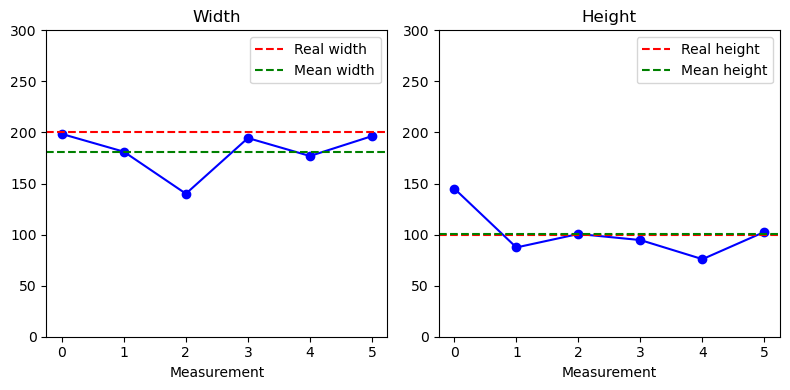

In [213]:
import numpy as np
import matplotlib.pyplot as plt

widths = []
heights = []

for i in range(3):
    width1 = tvecs[4*i] - tvecs[1+4*i]
    width1 = np.linalg.norm(width1)
    width2 = tvecs[2+4*i] - tvecs[3+4*i]
    width2 = np.linalg.norm(width2)
    height1 = tvecs[2+4*i] - tvecs[4*i]
    height1 = np.linalg.norm(height1)
    height2 = tvecs[3+4*i] - tvecs[1+4*i]
    height2 = np.linalg.norm(height2)
    
    widths.extend([width1, width2])
    heights.extend([height1, height2])

# 평균 계산
mean_width = np.mean(widths)
mean_height = np.mean(heights)

# 분산 계산
var_width = np.var(widths)
var_height = np.var(heights)

# 정확도 계산
real_width = 200
real_height = 100

accuracy_width = 1 - abs(mean_width - real_width) / real_width
accuracy_height = 1 - abs(mean_height - real_height) / real_height

# ANSI 이스케이프 시퀀스를 사용하여 bold 처리
print(f"\033[1mAccuracy of width: {accuracy_width:.2%}\033[0m")
print(f"\033[1mAccuracy of height: {accuracy_height:.2%}\033[0m")
print(f"\033[1mMean width: {mean_width:.2f}\033[0m")
print(f"\033[1mMean height: {mean_height:.2f}\033[0m")
print(f"\033[1mVariance of width: {var_width:.2f}\033[0m")
print(f"\033[1mVariance of height: {var_height:.2f}\033[0m")

# 시각화
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # plot 크기 조정

axs[0].plot(widths, 'bo-')
axs[0].set_ylim(0, 300) 
axs[0].axhline(real_width, color='r', linestyle='--', label='Real width')
axs[0].axhline(mean_width, color='g', linestyle='--', label='Mean width')
axs[0].set_title("Width")
axs[0].set_xlabel("Measurement")
axs[0].legend()

axs[1].plot(heights, 'bo-')
axs[1].set_ylim(0, 300)
axs[1].axhline(real_height, color='r', linestyle='--', label='Real height')
axs[1].axhline(mean_height, color='g', linestyle='--', label='Mean height')
axs[1].set_title("Height")
axs[1].set_xlabel("Measurement")
axs[1].legend()

plt.tight_layout()
plt.show()

In [106]:
import cv2
import numpy as np

# 카메라 내부 파라미터 및 왜곡 계수
camera_matrix = np.array([[3144.89, 0, 1534.82],
                          [0, 3162.3, 1582.55],
                          [0, 0, 1]])
dist_coeffs = np.array([0.35, -1.11, 0.03, -0.0, 1.52])

# 각 이미지의 마커 위치
marker_positions_list = [
    np.array([[2656.648, 1784.43], [803.386, 1831.242]], dtype=np.float32),
    np.array([[996.511, 951.586], [2742.0, 999.5]], dtype=np.float32),
    np.array([[2435.521, 2091.19], [916.401, 2107.507]], dtype=np.float32),
    np.array([[2392.003, 1804.191], [889.202, 1820.419]], dtype=np.float32),
    np.array([[2235.689, 1697.414], [841.096, 1722.68]], dtype=np.float32)
]

# 첫 번째 이미지의 실제 거리
actual_distance_first_image = 20

# 각 이미지에서의 실제 거리 추정값을 저장할 리스트
estimated_distances = []

# 첫 번째 이미지의 왜곡 보정 및 정규화된 이미지 좌표 계산
undistorted_points_img1 = cv2.undistortPoints(marker_positions_list[0], camera_matrix, dist_coeffs, P=camera_matrix)
point1_img1 = undistorted_points_img1[0][0]
point2_img1 = undistorted_points_img1[1][0]

# 첫 번째 이미지에서의 이미지 평면 거리 계산
image_distance_img1 = np.linalg.norm(point1_img1 - point2_img1)

# 스케일 팩터 계산
scale_factor = actual_distance_first_image / image_distance_img1

# 나머지 이미지에서의 실제 거리 추정
for marker_positions in marker_positions_list:
    undistorted_points = cv2.undistortPoints(marker_positions, camera_matrix, dist_coeffs, P=camera_matrix)
    point1 = undistorted_points[0][0]
    point2 = undistorted_points[1][0]
    image_distance = np.linalg.norm(point1 - point2)
    actual_distance = image_distance * scale_factor
    estimated_distances.append(actual_distance)

# 추정된 실제 거리의 평균 및 분산 계산
estimated_distances = np.array(estimated_distances)
mean_distance = np.mean(estimated_distances)
variance_distance = np.var(estimated_distances)

# 결과 출력
print("추정된 실제 거리들:", estimated_distances)
print("평균 거리:", mean_distance)
print("분산:", variance_distance)


추정된 실제 거리들: [20.    19.004 16.332 16.31  15.21 ]
평균 거리: 17.371177730505785
분산: 3.290173767905621


In [131]:
import cv2
import numpy as np

np.set_printoptions(precision=3, suppress=True)
wp = 9 # calibration pattern 가로점 수
hp = 5 # calibration pattern 세로점 수
length = 25 # calibration pattern 한 변 길이
directory = 'chess/'

imageExtension = '.jpg' # 파일 확장자
startImageNum = 1 # 읽기 시작하는 사진 번호
endImageNum = 2 # 읽기를 끝내는 사진 번호 + 1

objp = np.zeros((wp*hp, 3), np.float32)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length

intrinsic = np.loadtxt(directory + "Cal_intrinsic.txt")
distorsion = np.loadtxt(directory + "Cal_distorsion.txt")

W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

tvecs = []
corners_list = []

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)
    print(corners)
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기
    if ret == True:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 성공')
        ret, rvec, tvec = cv2.solvePnP(objp, corners, intrinsic, distorsion)
        cv2.Rodrigues(rvec, R)
        W[0:3, 0:3] = R
        W[0:3, 3:4] = tvec  # np.reshape(tvec,(3,1))
        print(f'{i}th HTM matrix W:\n{W}')

        # tvec 및 corners의 특정 인덱스 값 저장
        tvecs.append(tvec.flatten())
        corners_subset = [corners[0][0].tolist(), corners[8][0].tolist(), corners[27][0].tolist()]
        corners_list.append(corners_subset)

    else:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 실패')

# numpy 배열로 변환하여 저장
tvecs = np.array(tvecs)
corners_list = np.array(corners_list)

print('tvec\n', tvecs)
print('corners', corners_list)

# # 함수 정의: 이미지에 점 그리기
# def draw_corners(image, corners, color=(0, 255, 0), radius=5):
#     for corner in corners:
#         # 코너 좌표를 정수형으로 변환하여 원 그리기
#         center = tuple(map(int, corner))
#         cv2.circle(image, center, radius, color, -1)  # 원 내부를 채움

# # 이미지 처리 반복문
# for i in range(startImageNum, endImageNum):
#     img = cv2.imread(directory + str(i) + imageExtension)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)
    
#     # 코너가 찾아진 경우에만 처리
#     if ret:
#         # 찾은 코너를 점으로 변환하여 이미지에 표시
#         corners = corners.reshape(-1, 2)  # 2차원 배열로 변환
#         draw_corners(img, corners)  # 코너를 원으로 그리기

#         # 변환된 이미지 저장
#         cv2.imwrite(directory + f"corners_visualized_{i}.jpg", img)

[[[2656.648 1784.43 ]]

 [[2411.185 1790.857]]

 [[2171.772 1795.78 ]]

 [[1936.199 1800.344]]

 [[1706.564 1805.299]]

 [[1479.041 1811.884]]

 [[1256.679 1818.063]]

 [[1030.643 1824.622]]

 [[ 803.386 1831.242]]

 [[2637.802 1548.534]]

 [[2394.373 1558.293]]

 [[2156.844 1565.34 ]]

 [[1925.549 1572.855]]

 [[1698.236 1578.916]]

 [[1476.    1586.241]]

 [[1255.758 1593.13 ]]

 [[1032.808 1599.53 ]]

 [[ 806.639 1605.524]]

 [[2619.934 1318.808]]

 [[2379.728 1330.709]]

 [[2145.538 1341.075]]

 [[1915.2   1350.665]]

 [[1691.456 1359.053]]

 [[1474.461 1366.546]]

 [[1253.648 1374.547]]

 [[1032.577 1379.85 ]]

 [[ 809.447 1385.374]]

 [[2603.45  1094.801]]

 [[2366.946 1109.27 ]]

 [[2135.064 1121.572]]

 [[1907.34  1133.48 ]]

 [[1685.968 1143.616]]

 [[1468.571 1152.825]]

 [[1251.652 1161.207]]

 [[1032.672 1166.503]]

 [[ 812.63  1171.382]]

 [[2586.523  876.218]]

 [[2353.781  890.383]]

 [[2125.     904.565]]

 [[1899.511  918.514]]

 [[1679.57   930.172]]

 [[1462.899  942

In [130]:
import cv2
import numpy as np

# 실제 길이
real_length = 200  # 단위: mm (20cm = 200mm)

# Marker 좌표
marker1_pos = np.array([2656.648, 1784.43], dtype=np.float32)  # Marker 1 좌표
marker2_pos = np.array([803.386, 1831.242], dtype=np.float32)  # Marker 2 좌표

# 이미지에서의 marker 사이 거리 계산
marker_distance_in_image = np.linalg.norm(marker1_pos - marker2_pos)

# Intrinsic matrix 로드
intrinsic_file = 'chess/Cal_intrinsic.txt'
intrinsic = np.loadtxt(intrinsic_file)

# 실제 길이 계산
fx = intrinsic[0, 0]  # Focal length x
fy = intrinsic[1, 1]  # Focal length y
px = intrinsic[0, 2]  # Principal point x
py = intrinsic[1, 2]  # Principal point y

# 이미지에서의 marker 사이 거리를 실제 거리로 변환
distance = real_length * fx / marker_distance_in_image

# 오차율 계산
error_rate = abs(distance - real_length) / real_length * 100

print(f"Calculated length: {distance:.2f} mm")
print(f"Real length: {real_length} mm")
print(f"Error rate: {error_rate:.2f}%")

Calculated length: 339.28 mm
Real length: 200 mm
Error rate: 69.64%


In [113]:
import numpy as np

# tvec 값
tvec = np.array([
    [[118.695], [20.678], [342.306]],
    [[-63.213], [-74.034], [369.97]],
    [[118.84], [65.598], [428.728]],
    [[114.225], [28.058], [429.304]],
    [[100.622], [15.107], [458.898]]
])

# corner 값
corner = np.array([
    [[2656.648, 1784.43], [803.386, 1831.242], [2603.45, 1094.801]],
    [[996.511, 951.586], [2742.0, 999.5], [981.967, 1588.831]],
    [[2435.521, 2091.19], [916.401, 2107.507], [2453.739, 1527.982]],
    [[2392.003, 1804.191], [889.202, 1820.419], [2444.443, 1261.391]],
    [[2235.689, 1697.414], [841.096, 1722.68], [2289.467, 1213.589]]
])

# width와 height를 저장할 리스트
widths = []
heights = []

# 각 corner의 width와 height 계산
for i in range(len(corner)):
    # tvec을 이용하여 corner 좌표를 세계 좌표로 변환
    transformed_corner = corner[i] + tvec[i]

    # width 계산 (corner[0]과 corner[1] 사이의 거리)
    width = np.linalg.norm(transformed_corner[0] - transformed_corner[1])
    widths.append(width)

    # height 계산 (corner[0]과 corner[2] 사이의 거리)
    height = np.linalg.norm(transformed_corner[0] - transformed_corner[2])
    heights.append(height)

# 결과 출력
for i, (width, height) in enumerate(zip(widths, heights), 1):
    print(f"Corner {i}:")
    print(f"Width: {width} units")
    print(f"Height: {height} units")
    print()


Corner 1:
Width: 1951.950739098198 units
Height: 496.1989186737511 units

Corner 2:
Width: 1735.0645408378905 units
Height: 1149.3801440363409 units

Corner 3:
Width: 1572.7955094890758 units
Height: 414.51727302490053 units

Corner 4:
Width: 1590.5064503940248 units
Height: 432.3506322442469 units

Corner 5:
Width: 1481.3337347353563 units
Height: 430.75637002486735 units



In [93]:
import cv2
import numpy as np

np.set_printoptions(precision=3, suppress=True)
wp = 9  # calibration pattern 가로점 수
hp = 5  # calibration pattern 세로점 수
length = 25  # calibration pattern 한 변 길이
directory = 'chess/'
imageExtension = '.jpg'  # 파일 확장자
startImageNum = 1  # 읽기 시작하는 사진 번호
endImageNum = 6  # 읽기를 끝내는 사진 번호 + 1
objp = np.zeros((wp*hp, 3), np.float32)
objp[:, :2] = np.mgrid[0:wp, 0:hp].T.reshape(-1, 2)
objp[:, :2] *= length
intrinsic = np.loadtxt('pattern/' + "Cal_intrinsic.txt")
distorsion = np.loadtxt('pattern/' + "Cal_distorsion.txt")
W = np.full((3, 4), 0.0)
R = np.full((3, 3), 0.0)

# 실제 거리 (기준 거리)
real_reference_distance = length * (wp - 1)  # 가로 길이

print(f"\n실제 가로 길이 (기준 거리): {real_reference_distance:.2f}mm")

lengths = []

for i in range(startImageNum, endImageNum):
    img = cv2.imread(directory + str(i) + imageExtension)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (wp, hp), None)
    img_shape = gray.shape[::-1]  # 사진의 가로 및 세로 크기

    if ret:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 성공')
        ret, rvec, tvec = cv2.solvePnP(objp, corners, intrinsic, distorsion)
        cv2.Rodrigues(rvec, R)
        W[0:3, 0:3] = R
        W[0:3, 3:4] = tvec.reshape(3, 1)  # tvec를 (3, 1) 형태로 변환

        # 첫 번째 이미지의 tvec를 기준으로 사용
        if i == startImageNum:
            tvec_ref = tvec.reshape(3, 1)  # tvec_ref를 (3, 1) 형태로 변환
        
        tvec_diff = tvec - tvec_ref
        
        # 실제 세계 좌표계 기준의 거리 벡터 계산
        distance_vector = intrinsic @ tvec_diff.reshape(3, 1)  # tvec_diff를 (3, 1) 형태로 변환
        
        # 실제 거리 계산
        real_distance = np.linalg.norm(distance_vector.reshape(3,))  # distance_vector를 (3,) 형태로 변환
        
        # 기준 거리를 사용한 스케일 조정 (옵션)
        corner0_3d = np.array([[corners[0][0][0], corners[0][0][1], 0]], dtype=np.float32)
        corner8_3d = np.array([[corners[1][0][0], corners[1][0][1], 0]], dtype=np.float32)
        
        corner0_2d, _ = cv2.projectPoints(corner0_3d, rvec, tvec, intrinsic, distorsion)
        corner8_2d, _ = cv2.projectPoints(corner8_3d, rvec, tvec, intrinsic, distorsion)
        
        reference_distance_px = np.linalg.norm(corner8_2d - corner0_2d)
        if reference_distance_px > 0:  # reference_distance_px가 0이 아닌 경우에만 scale_factor를 계산
            scale_factor = real_reference_distance / reference_distance_px
            real_distance *= scale_factor
        
        # 거리 리스트에 추가
        lengths.append(real_distance)
        
        print(f'{i}th HTM matrix W:\n{W}')
        print(f'추정된 거리: {real_distance:.2f}mm')

        np.savetxt(directory + "\HTM_" + str(i) + ".txt", W, fmt='%.2f')  # extrinsic matrix 저장
    else:
        print(f'{i}번째 이미지에서 pattern 특징점 인식 실패')

# 거리 측정값들에 대한 평균과 분산 계산
lengths_array = np.array(lengths)
lengths_mean = np.mean(lengths_array)
lengths_variance = np.var(lengths_array)

print(f'\n거리 측정값들의 평균: {lengths_mean:.2f}mm')
print(f'거리 측정값들의 분산: {lengths_variance:.2f}')


실제 가로 길이 (기준 거리): 200.00mm
1번째 이미지에서 pattern 특징점 인식 성공
1th HTM matrix W:
[[ -0.997  -0.025   0.073 118.43 ]
 [  0.033  -0.993   0.115  20.025]
 [  0.07    0.117   0.991 339.849]]
추정된 거리: 0.00mm
2번째 이미지에서 pattern 특징점 인식 성공
2th HTM matrix W:
[[  0.999  -0.032   0.036 -63.436]
 [  0.035   0.995  -0.093 -74.837]
 [ -0.033   0.095   0.995 368.753]]
추정된 거리: 0.96mm
3번째 이미지에서 pattern 특징점 인식 성공
3th HTM matrix W:
[[ -1.     -0.008  -0.019 118.633]
 [  0.011  -0.982  -0.191  64.881]
 [ -0.017  -0.191   0.981 425.706]]
추정된 거리: 0.00mm
4번째 이미지에서 pattern 특징점 인식 성공
4th HTM matrix W:
[[ -1.     -0.003  -0.024 114.027]
 [  0.012  -0.928  -0.372  27.231]
 [ -0.022  -0.372   0.928 426.847]]
추정된 거리: 0.00mm
5번째 이미지에서 pattern 특징점 인식 성공
5th HTM matrix W:
[[ -1.     -0.011  -0.017 100.339]
 [  0.018  -0.869  -0.494  14.217]
 [ -0.009  -0.494   0.869 456.782]]
추정된 거리: 0.01mm

거리 측정값들의 평균: 0.19mm
거리 측정값들의 분산: 0.15


In [58]:
# 체스보드 크기 추정
def estimate_chessboard_size(corners_list, length, wp, hp):
    num_images = len(corners_list)
    chessboard_size = np.zeros((num_images, 2))  # 가로, 세로 크기 저장할 배열
    
    for i in range(num_images):
        # 가로 방향의 코너 점 사이의 픽셀 거리 계산
        corners_diff_x = corners_list[i][1][0] - corners_list[i][0][0]
        pixel_dist_x = np.abs(corners_diff_x)
        
        # 세로 방향의 코너 점 사이의 픽셀 거리 계산
        corners_diff_y = corners_list[i][3][1] - corners_list[i][0][1]
        pixel_dist_y = np.abs(corners_diff_y)
        
        # 실제 거리와 픽셀 거리 비율로 체스보드 크기 계산
        chessboard_size[i, 0] = (wp - 1) * length * pixel_dist_x / (wp - 1)
        chessboard_size[i, 1] = (hp - 1) * length * pixel_dist_y / (hp - 1)
    
    return chessboard_size

# 체스보드 크기 추정 함수 호출
estimated_size = estimate_chessboard_size(corners_list, length, wp, hp)

# 결과 출력
print("Estimated chessboard size:")
print("Width: {:.2f} mm".format(np.mean(estimated_size[:, 0])))
print("Height: {:.2f} mm".format(np.mean(estimated_size[:, 1])))

Estimated chessboard size:
Width: 50736.89 mm
Height: 18920.87 mm


In [46]:
##### import numpy as np
import cv2

num = 10

print(corners_list[num])
# 코너 좌표 (각 꼭짓점의 2D 이미지 평면 좌표)
corners = corners_list[num]

# 카메라 내부 파라미터
K = np.array([[3144.89, 0.0, 1534.82],
                [0.0, 3162.30, 1582.55],
                [0.0, 0.0, 1.0]])

# 각 코너 점의 3D 좌표 (z값은 0으로 가정)
corners_3d = np.hstack((corners, np.zeros((corners.shape[0], 1))))

# 동차 좌표로 변환
corners_3d_homogeneous = np.hstack((corners_3d, np.ones((corners.shape[0], 1)))).T

# 변환 행렬 구성
T = np.eye(4)
T[:3, 3] = tvecs[num].flatten()

# 3D 좌표 변환
transformed_3d_homogeneous = T @ corners_3d_homogeneous
transformed_3d = transformed_3d_homogeneous[:3]  # 동차 좌표에서 변환된 3D 좌표 추출

# 2D 이미지 평면으로 투영
projected_2d_homogeneous = K @ transformed_3d
projected_2d = projected_2d_homogeneous[:2] / projected_2d_homogeneous[2]

# 결과 출력
print("변환된 2D 이미지 평면 좌표:")
print(projected_2d.T)

# 주어진 변환된 2D 이미지 평면 좌표
points = projected_2d.T

# 각 변의 길이 계산
width1 = np.linalg.norm(points[0] - points[1])
width2 = np.linalg.norm(points[2] - points[3])
height1 = np.linalg.norm(points[0] - points[2])
height2 = np.linalg.norm(points[1] - points[3])

# 평균 가로와 세로 길이 계산
average_width = (width1 + width2) / 2
average_height = (height1 + height2) / 2

print(f"가로 길이: {average_width}")
print(f"세로 길이: {average_height}")

[[ 833.978 1065.242]
 [2379.048 1119.816]
 [ 846.66  1612.475]
 [2333.048 1708.972]]
변환된 2D 이미지 평면 좌표:
[[ 5685.358  7283.848]
 [14657.614  7602.516]
 [ 5759.005 10479.232]
 [14390.494 11042.695]]
가로 길이: 8813.887493882328
세로 길이: 3323.383160208202


In [60]:
import cv2
import numpy as np
import glob

# 실제 사각형 크기 (단위: mm)
real_width = 200
real_height = 100

# 이미지 디렉토리 설정
img_dir = 'object/'
img_format = 'jpg'  # 이미지 파일 형식

# 이미지 파일 목록 가져오기
img_files = glob.glob(img_dir + '*.' + img_format)

# 내부 파라미터 설정 (이전에 계산된 값 사용)
mtx = np.array([[3145.68, 0.0, 1536.87],
                [0.0, 3158.93, 1588.56],
                [0.0, 0.0, 1.0]])

# 사각형 크기 계산 함수
def calculate_rect_size(img_file, mtx):
    img = cv2.imread(img_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 적응형 이진화
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # 컨투어 검출
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        # 가장 큰 컨투어 선택
        max_contour = max(contours, key=cv2.contourArea)
        
        # 컨투어의 근사화된 다각형 검출
        epsilon = 0.02 * cv2.arcLength(max_contour, True)
        approx = cv2.approxPolyDP(max_contour, epsilon, True)
        
        if len(approx) == 4:
            # 사각형의 네 꼭짓점 좌표 계산
            rect = np.zeros((4, 2), dtype=np.float32)
            rect[0] = approx[0, 0]
            rect[1] = approx[1, 0]
            rect[2] = approx[2, 0]
            rect[3] = approx[3, 0]
            
            # 픽셀 단위 크기 계산
            pixel_width1 = np.sqrt(np.sum((rect[0] - rect[1])**2))
            pixel_width2 = np.sqrt(np.sum((rect[2] - rect[3])**2))
            pixel_height1 = np.sqrt(np.sum((rect[1] - rect[2])**2))
            pixel_height2 = np.sqrt(np.sum((rect[3] - rect[0])**2))
            
            # 실제 크기 계산
            fx = mtx[0, 0]
            fy = mtx[1, 1]
            
            rect_width1 = pixel_width1 * real_width / fx
            rect_width2 = pixel_width2 * real_width / fx
            rect_height1 = pixel_height1 * real_height / fy
            rect_height2 = pixel_height2 * real_height / fy
            
            rect_width = (rect_width1 + rect_width2) / 2
            rect_height = (rect_height1 + rect_height2) / 2
            
            # 검출된 사각형의 꼭짓점에 색칠하기
            for point in approx:
                cv2.circle(img, tuple(point[0]), 5, (0, 255, 0), -1)
            
            # 결과 이미지 저장
            result_file = img_file.replace('.jpg', '_result.jpg')
            cv2.imwrite(result_file, img)
            
            return rect_width, rect_height
    
    return None, None

# 사각형 크기 계산 및 결과 저장
rect_sizes = []
for img_file in img_files:
    width, height = calculate_rect_size(img_file, mtx)
    if width is not None:
        rect_sizes.append((width, height))
        print(f"{img_file}: 가로 {width:.2f}mm, 세로 {height:.2f}mm")
    else:
        print(f"{img_file}: 사각형 검출 실패")

# 결과 분석
if len(rect_sizes) > 0:
    mean_width = np.mean([size[0] for size in rect_sizes])
    mean_height = np.mean([size[1] for size in rect_sizes])
    
    std_width = np.std([size[0] for size in rect_sizes])
    std_height = np.std([size[1] for size in rect_sizes])
    
    print(f"\n가로 평균: {mean_width:.2f}mm, 표준편차: {std_width:.2f}mm")
    print(f"세로 평균: {mean_height:.2f}mm, 표준편차: {std_height:.2f}mm")
    
    # 실제 크기와의 차이 계산
    diff_width = abs(mean_width - real_width)
    diff_height = abs(mean_height - real_height)
    
    # 백분율로 계산
    percent_width = (diff_width / real_width) * 100
    percent_height = (diff_height / real_height) * 100
    
    print(f"\n실제 가로 크기와의 차이: {diff_width:.2f}mm ({percent_width:.2f}%)")
    print(f"실제 세로 크기와의 차이: {diff_height:.2f}mm ({percent_height:.2f}%)")
else:
    print("사각형 크기 계산 실패")

object\1.jpg: 사각형 검출 실패
object\2.jpg: 가로 106.98mm, 세로 28.21mm
object\2_result.jpg: 가로 107.41mm, 세로 28.43mm
object\3.jpg: 가로 103.80mm, 세로 27.18mm
object\3_result.jpg: 사각형 검출 실패
object\4.jpg: 가로 42.63mm, 세로 51.94mm
object\4_result.jpg: 사각형 검출 실패
object\5.jpg: 가로 37.96mm, 세로 51.04mm
object\5_result.jpg: 가로 38.30mm, 세로 51.25mm

가로 평균: 72.85mm, 표준편차: 33.27mm
세로 평균: 39.67mm, 표준편차: 11.74mm

실제 가로 크기와의 차이: 127.15mm (63.58%)
실제 세로 크기와의 차이: 60.33mm (60.33%)
